In [1]:
import torch
from torch import nn
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import sys
import json


sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
device = torch.device(device)
print(f"Using {device} device")

Using cuda device


In [2]:
from src import get_data_loaders

data_dir = os.path.join(os.getcwd(), 'Data', 'Parsed_Data_Corrected')
faste_files_to_load = 37
normalize = False
num_train_val_data = math.inf
num_test_data = math.inf
batch_size = 128
upper_threshold = True
lower_threshold = False
min_coverage = None
max_coverage = 20_000


train_loader, val_loader, test_loader = get_data_loaders(data_dir,
                                                            batch_size=batch_size,
                                                            faste_files_to_load=faste_files_to_load, 
                                                            normalize=normalize, 
                                                            train_val_data_to_load=num_train_val_data, 
                                                            test_data_to_load=num_test_data,
                                                            upper_threshold=upper_threshold,
                                                            lower_threshold=lower_threshold,
                                                            minimum_coverage=min_coverage,
                                                            maximum_coverage=max_coverage)


Loading sequences from sequences.fasta
Loading coverage from SRX9770776.faste
Loading coverage from SRX9770789.faste
Loading coverage from SRX9770788.faste
Loading coverage from SRX9770777.faste
Loading coverage from SRX9770785.faste
Loading coverage from SRX9770782.faste
Loading coverage from SRX9770790.faste
Loading coverage from SRX9770791.faste
Loading coverage from SRX9770783.faste
Loading coverage from SRX9770784.faste
Loading coverage from SRX9770793.faste
Loading coverage from SRX9770786.faste
Loading coverage from SRX9770779.faste
Loading coverage from SRX9770781.faste
Loading coverage from SRX9770780.faste
Loading coverage from SRX9770778.faste
Loading coverage from SRX9770787.faste
Loading coverage from SRX9770792.faste
Loading coverage from SRX9770775.faste
Loading coverage from SRX9770774.faste
Loading coverage from SRX9770773.faste
Loading coverage from SRX391994.faste
Loading coverage from SRX391993.faste
Loading coverage from SRX391992.faste
Loading coverage from SRX391

In [13]:
from src import DeepCNN

# build model
save_dir = os.path.join(os.getcwd(), 'Model_DeepCNN')
os.makedirs(save_dir, exist_ok=True)

num_kernels=[128,64,64] # [32,16,8]
kernel_size=[24,4,4] # [8,4,2]
dropout=0.2

if True:
    parms = {'num_kernels': num_kernels,
         'kernel_size': kernel_size,
        'dropout': dropout,
    }
    with open(os.path.join(save_dir, 'model_parameters.json'), 'w') as f:
        json.dump(parms, f, indent=4)

    model = DeepCNN(num_kernels=num_kernels,
                    kernel_size=kernel_size,
                    dropout=dropout,
                    output_size=faste_files_to_load
                    ).to(device)

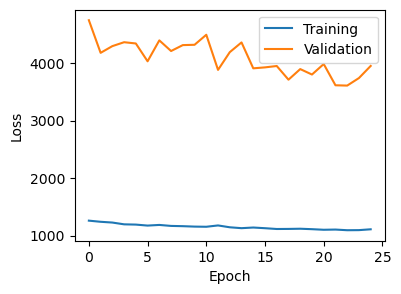

Training loss 1108.9299778702236 is less than half of validation loss 3953.8615273662


In [ ]:
from src import train_model

lr = 0.01
epochs = 500
patientce = 50
log_input = True
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.PoissonNLLLoss(log_input=log_input, full=True)
train_model(device, train_loader, val_loader, model, optimizer, loss_fn, epochs, save_dir, patientce)

In [ ]:
X, y = next(iter(train_loader))
y_pred = model(X.to(device))
i = 2
print('Tissue: Predicted, True')
for s, (y_p, y_t) in enumerate(zip(y_pred[i], y[i])):
    if log_input:
        y_p = torch.exp(y_p)
    print(f'{s}: {y_p:.3f}, {y_t:.3f}')

Tissue: Predicted, True
0: 146.665, 1179.282
1: 210.853, 1796.570
2: 146.212, 1445.655
3: 177.599, 3175.596
4: 140.921, 1890.920
5: 164.074, 2206.280
6: 185.444, 1433.273
7: 187.629, 1330.252
8: 176.796, 1942.658
9: 161.867, 2442.022
10: 208.483, 1797.797
11: 149.812, 1344.986
12: 172.264, 2418.437
13: 164.264, 1637.676
14: 152.260, 1804.147
15: 133.755, 1432.908
16: 151.948, 1167.045
17: 189.424, 1610.041
18: 146.255, 1494.556
19: 185.820, 1885.545
20: 155.729, 2050.489
21: 210.970, 1158.635
22: 171.361, 796.361
23: 244.065, 2963.212
24: 137.147, 931.232
25: 180.110, 1750.778
26: 169.757, 771.657
27: 273.609, 2629.175
28: 170.000, 1029.175
29: 184.804, 1825.880
30: 182.304, 1635.554
31: 160.269, 2036.375
32: 253.416, 2987.885
33: 275.088, 3341.589
34: 189.598, 1354.325
35: 237.870, 2054.983
36: 156.280, 1361.620


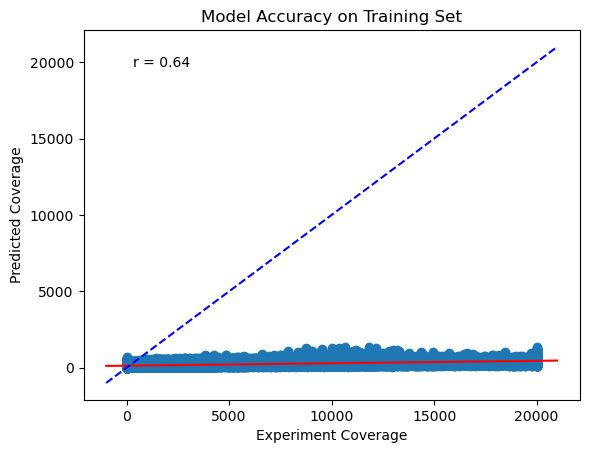

In [ ]:
with torch.no_grad():
        model.eval()
        pred_list = []
        labels_list = []
        for batch_index, (X, y) in enumerate(train_loader):
            X = X.to(device)
            y = y.to(device)

            if log_input:
                y_pred = torch.exp(model(X))
            else:
                y_pred = model(X)
            
            y_pred = torch.flatten(y_pred).cpu().detach().numpy()
            pred_list.append(y_pred)

            y = torch.flatten(y).cpu().numpy()
            labels_list.append(y)
            
        labels = np.concatenate(labels_list)
        predictions = np.concatenate(pred_list)
        
pearson_r = np.corrcoef(labels, predictions)[0, 1]

plt.scatter(labels, predictions)
plt.xlabel("Experiment Coverage")
plt.ylabel("Predicted Coverage")
plt.title("Model Accuracy on Training Set")
plt.text(0.1, 0.9, f"r = {pearson_r:.2f}", transform=plt.gca().transAxes)
m, b = np.polyfit(y, y_pred, 1)
X_plot = np.linspace(plt.gca().get_xlim()[0], plt.gca().get_xlim()[1], 100)
plt.plot(X_plot, m * X_plot + b, '-', color='red')
plt.plot(X_plot, X_plot, '--', color='blue', label='y = x')
plt.savefig(os.path.join(save_dir, 'TrainingAccuracy.png'), dpi=300)
plt.show()

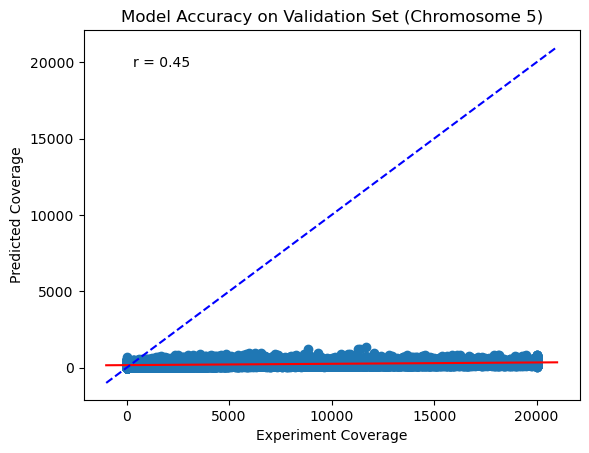

In [ ]:
with torch.no_grad():
        model.eval()
        pred_list = []
        labels_list = []
        for batch_index, (X, y) in enumerate(val_loader):
            X = X.to(device)
            y = y.to(device)

            if log_input:
                y_pred = torch.exp(model(X))
            else:
                y_pred = model(X)

            y_pred = torch.flatten(y_pred).cpu().detach().numpy()
            pred_list.append(y_pred)

            y = torch.flatten(y).cpu().numpy()
            labels_list.append(y)
            
        labels = np.concatenate(labels_list)
        predictions = np.concatenate(pred_list)
        
pearson_r = np.corrcoef(labels, predictions)[0, 1]

plt.scatter(labels, predictions)
plt.xlabel("Experiment Coverage")
plt.ylabel("Predicted Coverage")
plt.title("Model Accuracy on Validation Set (Chromosome 5)")
plt.text(0.1, 0.9, f"r = {pearson_r:.2f}", transform=plt.gca().transAxes)
m, b = np.polyfit(y, y_pred, 1)
X_plot = np.linspace(plt.gca().get_xlim()[0], plt.gca().get_xlim()[1], 100)
plt.plot(X_plot, m * X_plot + b, '-', color='red')
plt.plot(X_plot, X_plot, '--', color='blue', label='y = x')
plt.savefig(os.path.join(save_dir, 'ValAccuracy.png'), dpi=300)
plt.show()

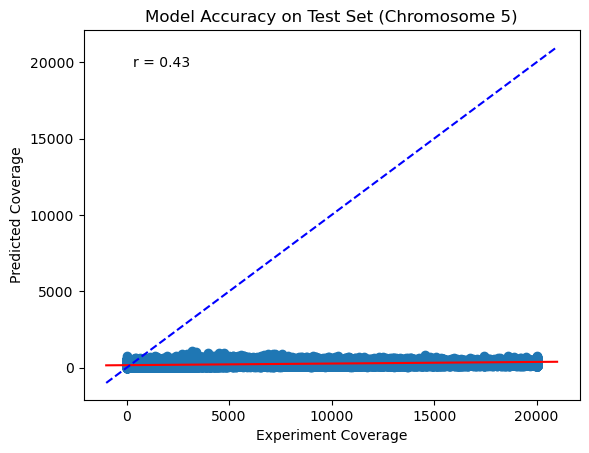

In [ ]:
with torch.no_grad():
        model.eval()
        pred_list = []
        labels_list = []
        for batch_index, (X, y) in enumerate(test_loader):
            X = X.to(device)
            y = y.to(device)
            if log_input:
                y_pred = torch.exp(model(X))
            else:
                y_pred = model(X)
            y_pred = torch.flatten(y_pred).cpu().detach().numpy()
            pred_list.append(y_pred)

            y = torch.flatten(y).cpu().numpy()
            labels_list.append(y)
            
        labels = np.concatenate(labels_list)
        predictions = np.concatenate(pred_list)
        
pearson_r = np.corrcoef(labels, predictions)[0, 1]

plt.scatter(labels, predictions)
plt.xlabel("Experiment Coverage")
plt.ylabel("Predicted Coverage")
plt.title("Model Accuracy on Test Set (Chromosome 5)")
plt.text(0.1, 0.9, f"r = {pearson_r:.2f}", transform=plt.gca().transAxes)
m, b = np.polyfit(y, y_pred, 1)
X_plot = np.linspace(plt.gca().get_xlim()[0], plt.gca().get_xlim()[1], 100)
plt.plot(X_plot, m * X_plot + b, '-', color='red')
plt.plot(X_plot, X_plot, '--', color='blue', label='y = x')
plt.savefig(os.path.join(save_dir, 'TestingAccuracy.png'), dpi=300)
plt.show()